## Trabajo Práctico Machine Learning Computer Vision

In [1]:
# imports de libs que usamos para leer y procesar datos en masa
import os
import csv
import zipfile

import numpy as np
import pandas as pd
from PIL import Image

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning: separar conjuntos de datos, evaluar exactitud, etc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# libs que usamos para construir y entrenar redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

Using TensorFlow backend.


## Análisis exploratorio sobre el conjunto de datos

### Dataset

El dataset que se va a utilizar para este TP se trata de imágenes de distintas clases de frutas, divididas por carpeta. El dataset se encuentra dividido en train y test. La idea es poder entrenar un modelo capaz de predecir que fruta hay en una imagen.

Fuente del dataset: https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras/data

Para poder utilizar este dataset, lo que hicimos fue generar dos archivos csv "train.csv" y "test.csv". 
Para esto lo que hicimos fue recorrer todas las carpetas y, mediante la libreria pillow, obtener los datos de la imagen con el método .load() y recorrer todos los pixeles de la misma, almacenando en el csv la "cantidad" de Rojo, la "cantidad" de Verde y la "cantidad" de Azul que posee por cada pixel. 

El código generado para esto fue el siguiente: 

```
width, height = 48, 48
channels = 3
directorio_training = 'data/fruits-360/Training/'
directorio_testing = 'data/fruits-360/Validation/'
columns = []

#Agregamos los nombres de las columnas a ambos csv.

for color in range(channels):
    count = 0
    for x in range(width):
        for y in range(height):
            if color == 0:
                columns.append("R" + str(count))
            elif color == 1: 
                columns.append("G" + str(count))
            elif color == 2: 
                columns.append("B" + str(count))
            count += 1
columns.append("nombres_frutas")
columns.append("path")

with open('train.csv', 'w+') as f:
    thewriter = csv.writer(f) 
    thewriter.writerow(columns)

with open('test.csv', 'w+') as f:
    thewriter = csv.writer(f)
    thewriter.writerow(columns)
    
fruta = ""
path = ""

#Recorremos la carpeta de Training, cargamos los datos de la imagen, recorremos todos los pixeles 
#y agregamos una nueva fila en el csv.

for subdir, dirs, files in os.walk(directorio_training):
    fruta = os.path.basename(subdir)
    for file in files:
        im = Image.open(os.path.join(subdir, file))
        path = os.path.join(subdir, file)        
        im.thumbnail((width,height))
        pix = im.load()        
        datos_imagen = []
        for color in range(channels):
            for x in range(width):
                for y in range(height):
                    if color == 0:                    
                        r = pix[x,y][0]
                        datos_imagen.append(r)
                    elif color == 1:
                        g = pix[x,y][1]
                        datos_imagen.append(g)
                    elif color == 2:
                        b = pix[x,y][2]                
                        datos_imagen.append(b) 
        datos_imagen.append(fruta)
        datos_imagen.append(path)
        with open('train.csv', 'a') as f:
            thewriter = csv.writer(f) 
            thewriter.writerow(datos_imagen)
            
fruta = ""
path = ""

#Recorremos la carpeta de Validation, cargamos los datos de la imagen, recorremos todos los pixeles 
#y agregamos una nueva fila en el csv.

for subdir, dirs, files in os.walk(directorio_testing):
    fruta = os.path.basename(subdir)
    for file in files:
        im = Image.open(os.path.join(subdir, file))
        path = os.path.join(subdir, file)
        im.thumbnail((width,height))
        pix = im.load()
        
        datos_imagen = []
        for color in range(channels):
            for x in range(width):
                for y in range(height):
                    if color == 0:                    
                        r = pix[x,y][0]
                        datos_imagen.append(r)
                    elif color == 1:
                        g = pix[x,y][1]
                        datos_imagen.append(g)
                    elif color == 2:
                        b = pix[x,y][2]                
                        datos_imagen.append(b) 
        datos_imagen.append(fruta)
        datos_imagen.append(path)
        with open('test.csv', 'a') as f:
            thewriter = csv.writer(f) 
            thewriter.writerow(datos_imagen)

```

### Volumetría de los datos

Como podemos ver, el archivo de train posee 31688 filas y 6914 columnas. La cantidad de columnas se debe a que nosotros hicimos un resize de la imagen a 48 pixeles, entonces las columnas del dataset son 48 pixeles de ancho x 48 pixeles de alto x 3 (canales RGB). 48 x 48 x 3 = 6912. A esto le sumamos una columna "nombres_frutas" que va a ser la correspondiente a la variable de salida. Y la columna "path" que posee la ruta relativa del archivo. 

En train el archivo es de 10657 filas y 6914 columnas. 

Descargar archivos de ambos datasets y dejarlos dentro de la carpeta data_tp3 (sin descomprimirlos).

* Link train: https://drive.google.com/open?id=1ywSt1lmjDmTm4dJ3OVyvAC6VtuORJimW
* Link test: https://drive.google.com/open?id=1nwcc6ubvFA2VoNAHDeaSBjRxa-SJeOkB

In [2]:
zf = zipfile.ZipFile('data_tp3/train_csv.zip')
train = pd.read_csv(zf.open('train.csv'))
train.shape

(31688, 6914)

In [3]:
zf = zipfile.ZipFile('data_tp3/test_csv.zip')
test = pd.read_csv(zf.open('test.csv'))
test.shape

(10657, 6914)

In [4]:
train.sample(10)

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B2296,B2297,B2298,B2299,B2300,B2301,B2302,B2303,nombres_frutas,path
26501,255,255,255,255,255,255,255,255,254,251,...,255,255,255,255,255,255,255,255,Clementine,data/fruits-360/Training/Clementine/r_81_100.jpg
17002,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Litchi,data/fruits-360/Training/Litchi/214_100.jpg
28032,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Grape White 2,data/fruits-360/Training/Grape White 2/r_184_1...
4181,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Tamarillo,data/fruits-360/Training/Tamarillo/303_100.jpg
775,253,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Golden 2,data/fruits-360/Training/Apple Golden 2/232_10...
7375,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Mango,data/fruits-360/Training/Mango/r_311_100.jpg
24457,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Salak,data/fruits-360/Training/Salak/r_93_100.jpg
21641,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Kumquats,data/fruits-360/Training/Kumquats/r_215_100.jpg
22538,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Raspberry,data/fruits-360/Training/Raspberry/r_168_100.jpg
16701,255,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,Carambula,data/fruits-360/Training/Carambula/r_37_100.jpg


In [5]:
test.sample(10)

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B2296,B2297,B2298,B2299,B2300,B2301,B2302,B2303,nombres_frutas,path
7016,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Cactus fruit,data/fruits-360/Validation/Cactus fruit/318_10...
4574,255,255,255,255,255,255,255,255,255,253,...,255,255,255,255,255,255,255,255,Pitahaya Red,data/fruits-360/Validation/Pitahaya Red/204_10...
37,255,255,255,255,255,255,255,254,253,255,...,255,255,255,255,255,255,255,255,Guava,data/fruits-360/Validation/Guava/r_267_100.jpg
3202,255,255,252,250,252,254,251,252,255,255,...,255,255,255,255,255,255,255,255,Orange,data/fruits-360/Validation/Orange/r_74_100.jpg
2128,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Cherry Rainier,data/fruits-360/Validation/Cherry Rainier/r2_2...
3107,254,255,255,255,255,255,255,255,255,252,...,255,255,255,255,255,255,255,255,Orange,data/fruits-360/Validation/Orange/r_47_100.jpg
238,255,255,253,253,254,255,254,253,254,255,...,255,255,255,255,255,255,255,255,Apple Golden 2,data/fruits-360/Validation/Apple Golden 2/326_...
2932,255,255,255,255,255,255,255,255,253,253,...,255,255,255,255,255,255,255,255,Grapefruit Pink,data/fruits-360/Validation/Grapefruit Pink/323...
2673,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Banana Red,data/fruits-360/Validation/Banana Red/93_100.jpg
1084,255,255,255,255,255,254,254,255,255,253,...,255,255,255,255,255,255,255,255,Huckleberry,data/fruits-360/Validation/Huckleberry/r_240_1...


### Variable de Salida

La variable de salida va a ser una etiqueta con el nombre de la fruta. 

A continuación vamos a ver los distintos tipos de clases de frutas que hay y la distribución de ambos conjuntos de datos con respecto a la variable de salida.

In [6]:
#Configuraciones generales respecto a las imágenes

PICTURE_SIZE = 48
CHANNELS = 'RGB'

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i) for i in range(PICTURE_SIZE ** 2)])

In [7]:
FRUTAS = sorted(train.nombres_frutas.unique())

for fruta in FRUTAS:
    print(fruta)

print("\n" + "Hay " + str(len(FRUTAS)) + " clases de frutas a clasificar en este dataset.")

Apple Braeburn
Apple Golden 1
Apple Golden 2
Apple Golden 3
Apple Granny Smith
Apple Red 1
Apple Red 2
Apple Red 3
Apple Red Delicious
Apple Red Yellow
Apricot
Avocado
Avocado ripe
Banana
Banana Red
Cactus fruit
Cantaloupe 1
Cantaloupe 2
Carambula
Cherry 1
Cherry 2
Cherry Rainier
Clementine
Cocos
Dates
Granadilla
Grape Pink
Grape White
Grape White 2
Grapefruit Pink
Grapefruit White
Guava
Huckleberry
Kaki
Kiwi
Kumquats
Lemon
Lemon Meyer
Limes
Litchi
Mandarine
Mango
Maracuja
Nectarine
Orange
Papaya
Passion Fruit
Peach
Peach Flat
Pear
Pear Abate
Pear Monster
Pear Williams
Pepino
Pineapple
Pitahaya Red
Plum
Pomegranate
Quince
Raspberry
Salak
Strawberry
Tamarillo
Tangelo

Hay 64 clases de frutas a clasificar en este dataset.


### Distribución de la variable de salida

                               #################### train labels ####################


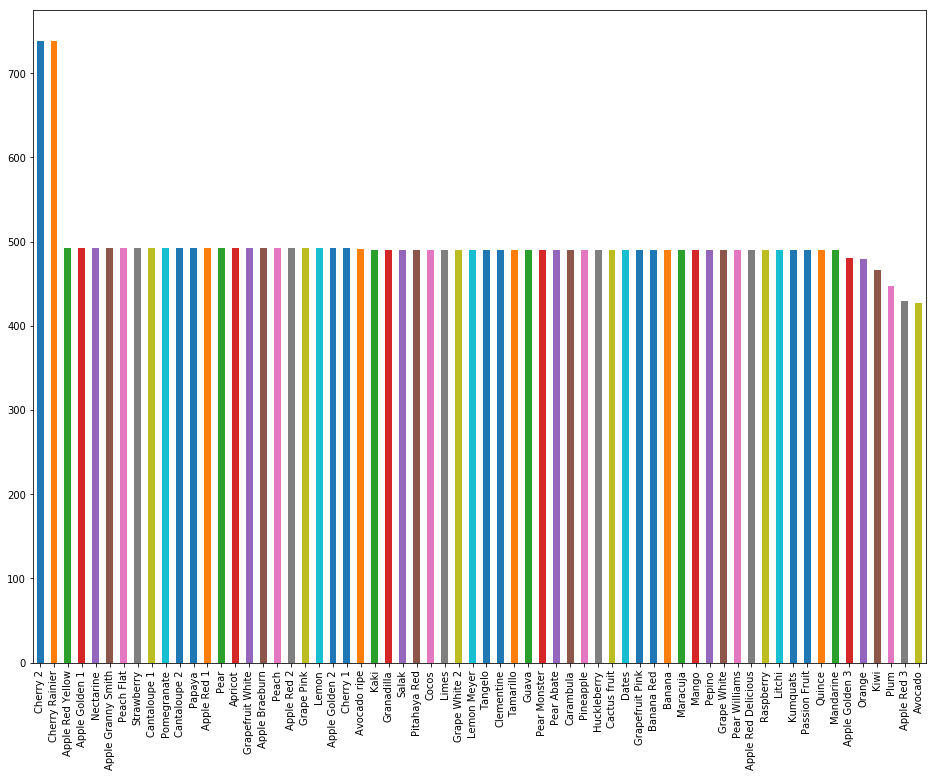

                               #################### test labels ####################


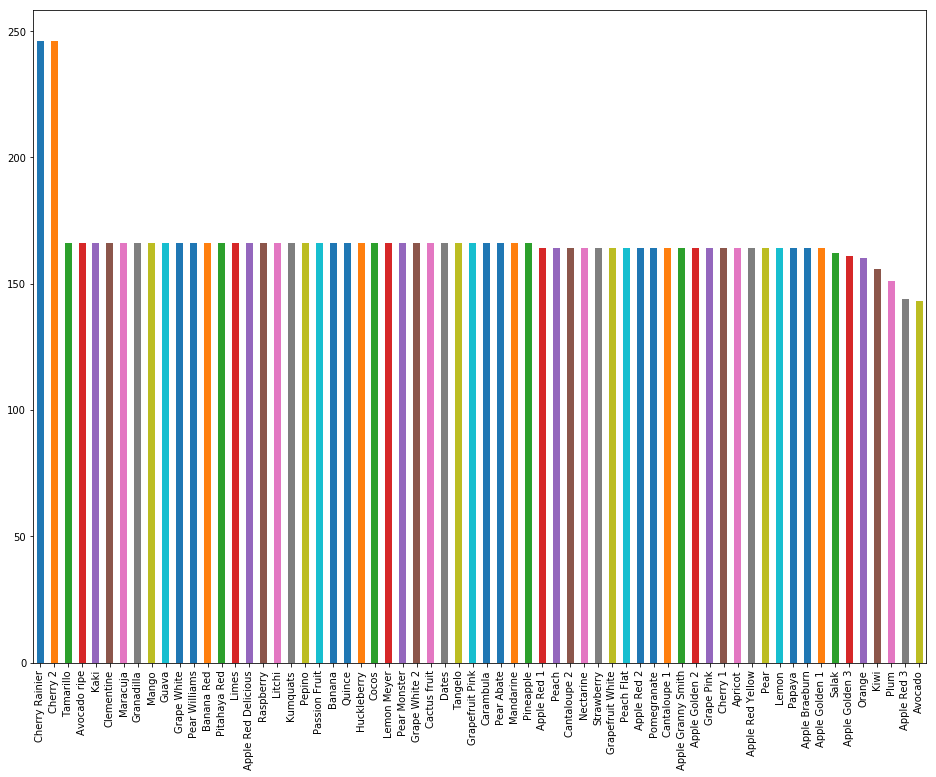

In [8]:
sets = (
    ('train', train),
    ('test', test),
)

for set_name, set_data in sets:
    print(' ' * 30,'#' * 20, set_name, 'labels', '#' * 20)
    set_data.nombres_frutas.value_counts().plot.bar(figsize=(16,12))
    plt.show()

In [9]:
#Función utilizada para mostrar imágenes.

def show_images(samples, title='file'):
    for index, sample in samples.iterrows():
        if  title is not None:
            if isinstance(title, str):
                title = [title, ]
            title_text = ', '.join(str(sample[title_field]) for title_field in title)
            plt.title(title_text)
            
        sample_as_grid = sample[INPUT_COLUMNS].values.reshape(len(CHANNELS), PICTURE_SIZE, PICTURE_SIZE).astype(np.float)
        sample_as_grid = np.transpose(sample_as_grid, (1,2,0)) / 255
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')
        plt.show()

### Visualización de imágenes

A continuación mostramos ejemplos al azar de imágenes para comprobar que se estén dibujando correctamente. 

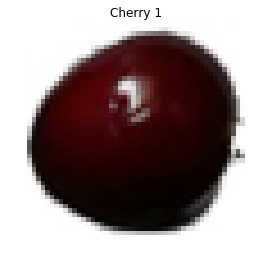

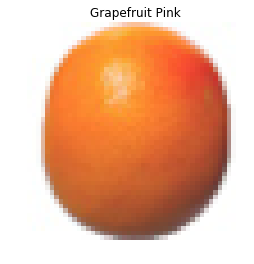

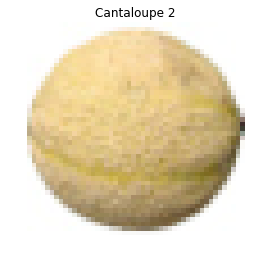

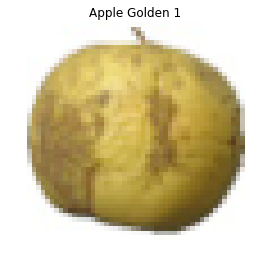

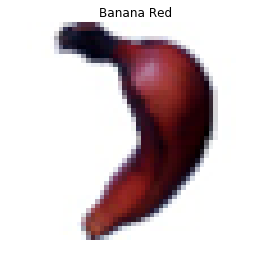

In [10]:
show_images(train.sample(5), 'nombres_frutas')

## Machine Learning

In [11]:
# Funciones para redes neuronales tradicionales 

def extract_inputs(dataset):
    return dataset[INPUT_COLUMNS].values / 255

def extract_inputs_convolutional(dataset):
    return dataset[INPUT_COLUMNS].values.reshape(len(dataset), PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255

def extract_outputs(dataset):
    is_fruits_columns = [(dataset.nombres_frutas == nombres_frutas).values for nombres_frutas in FRUTAS]
    return np.array(is_fruits_columns).T

In [12]:
# Funcion para evaluar la performance de la red neuronal

def add_predictions(dataset): 
    predictions = model_traditional.predict(extract_inputs(dataset))
    
    for fruit_number, fruit in enumerate(FRUTAS):
        dataset[fruit] = predictions[:, fruit_number]
    dataset['prediction'] = dataset[FRUTAS].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[FRUTAS].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.nombres_frutas
    
def add_predictions_convolutional(dataset): 
    predictions = model_convolutional.predict(extract_inputs_convolutional(dataset))
    
    for fruit_number, fruit in enumerate(FRUTAS):
        dataset[fruit] = predictions[:, fruit_number]
    dataset['prediction'] = dataset[FRUTAS].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[FRUTAS].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.nombres_frutas

### Red Neuronal MLP

Como primer técnica creamos un modelo de red neuronal MLP (tradicional). 

Definimos 3 capas con activación relu y la capa de salida con activación softmax. 

Utilizamos "dropouts" a modo de prevenir un poco el posible sobreentrenamiento de la red. 



In [13]:
model_traditional = Sequential([
    Dense(1000, activation='relu', input_shape=(len(INPUT_COLUMNS), )),
    
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(300, activation='relu'),
    Dropout(0.2),
    
    Dense(len(FRUTAS), activation='softmax'),
])

model_traditional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

model_traditional.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              6913000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                19264     
Total params: 7,583,064
Trainable params: 7,583,064
Non-trainable params: 0
_________________________________________________________________


Entrenamos el modelo.

In [14]:
history_traditional = model_traditional.fit(
    extract_inputs(train),
    extract_outputs(train),
    epochs=8,
    batch_size=128,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Train on 31688 samples, validate on 10657 samples
Epoch 1/8
31688/31688 [==============================] - 153s 5ms/step - loss: 1.8479 - acc: 0.4950 - val_loss: 0.5241 - val_acc: 0.8390
Epoch 2/8
31688/31688 [==============================] - 129s 4ms/step - loss: 0.3314 - acc: 0.8871 - val_loss: 0.3003 - val_acc: 0.8999
Epoch 3/8
31688/31688 [==============================] - 130s 4ms/step - loss: 0.1678 - acc: 0.9411 - val_loss: 0.2860 - val_acc: 0.8891
Epoch 4/8
31688/31688 [==============================] - 130s 4ms/step - loss: 0.1447 - acc: 0.9495 - val_loss: 0.3586 - val_acc: 0.8826
Epoch 5/8
31688/31688 [==============================] - 131s 4ms/step - loss: 0.0904 - acc: 0.9654 - val_loss: 0.2229 - val_acc: 0.9412
Epoch 6/8
31688/31688 [==============================] - 130s 4ms/step - loss: 0.0786 - acc: 0.9703 - val_loss: 0.2228 - val_acc: 0.9375
Epoch 7/8
31688/31688 [==============================] - 131s 4ms/step - loss: 0.0745 - acc: 0.9721 - val_loss: 0.2101 - val_acc

Comparamos las curvas de aprendizaje. 

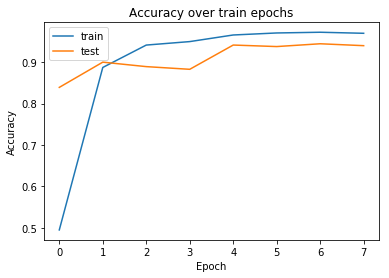

In [15]:
plt.plot(history_traditional.history['acc'], label='train')
plt.plot(history_traditional.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

A continuación vamos a visualizar la matriz de confusión de ambos set de datos, esto puede ayudarnos a definir con qué valores está teniendo problemas el modelo, si hay frutas que está prediciendo siempre o si hay frutas con las que tiene gran dificultad en predecirlas. 

                               ######################### train #########################
accuracy 0.989270386266
precision_score 0.993375906768
recall 0.989201717272


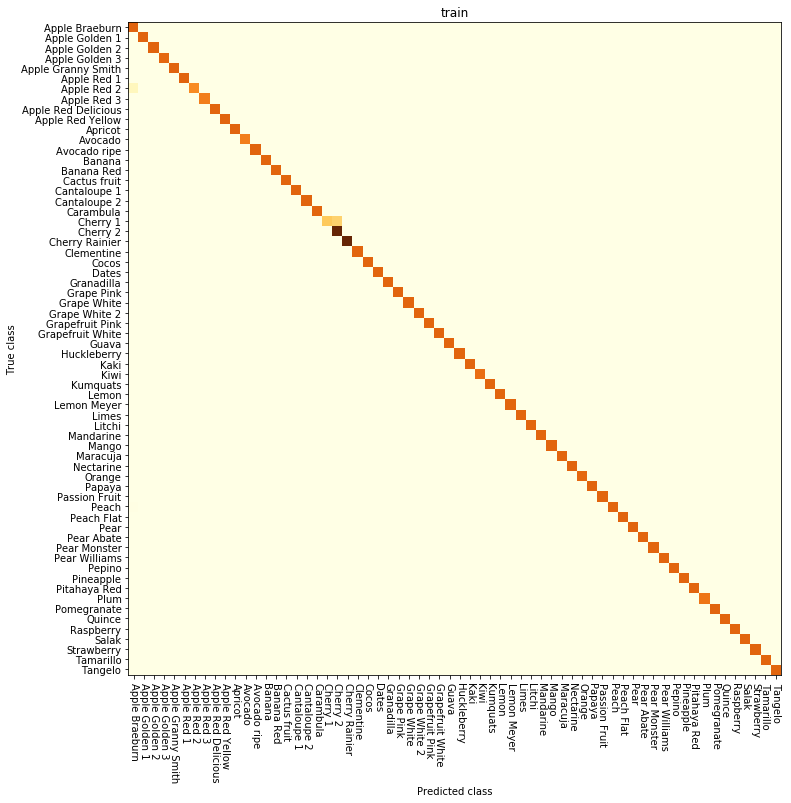

                               ######################### test #########################
accuracy 0.939664070564
precision_score 0.951002259541
recall 0.941143001886


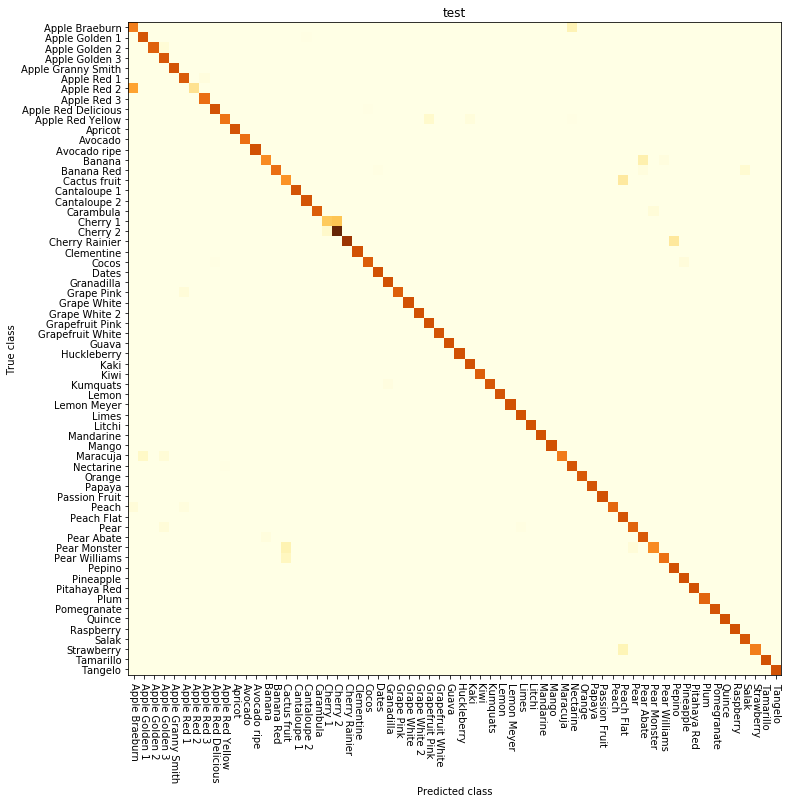

In [16]:
numeros_frutas = [i for i in range(len(FRUTAS))]
for set_name, set_data in sets:
    add_predictions(set_data)
    
    print(' ' * 30,'#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(set_data.nombres_frutas, set_data.prediction))
    print('precision_score', precision_score(set_data.nombres_frutas, set_data.prediction, average="macro"))
    print('recall', recall_score(set_data.nombres_frutas, set_data.prediction, average="macro"))
    
    # plot confussion matrix
    
    plt.figure(figsize=(16,12))
    
    plt.xticks(numeros_frutas, FRUTAS, rotation=270)
    plt.yticks(numeros_frutas, FRUTAS)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    
    plt.title(set_name)
    
    plt.imshow(
        confusion_matrix(set_data.nombres_frutas, set_data.prediction),
        cmap=plt.cm.YlOrBr,
        interpolation='nearest',
    )
    
    plt.show()

Para finalizar con este modelo, podemos mostrar ejemplos de predicciones realizadas por el mismo. 

#### Predicciones correctas

En la imagen se muestra el valor que predijo el modelo, el valor de "confianza", y la fruta que era en realidad.

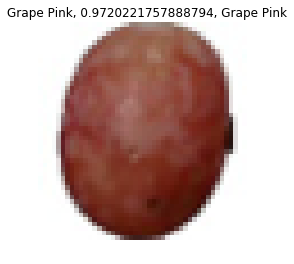

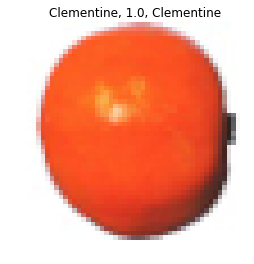

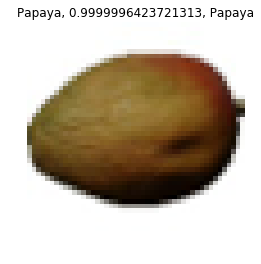

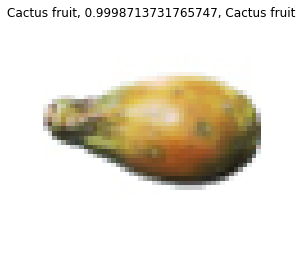

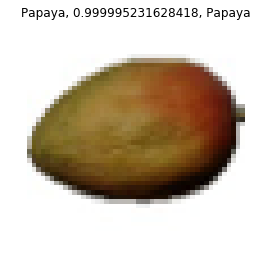

In [17]:
show_images(test[test.nombres_frutas == test.prediction].sample(5), title=['prediction', 'prediction_confidence', 'nombres_frutas'])

#### Predicciones incorrectas

En la imagen se muestra el valor que predijo el modelo, el valor de "confianza", y la fruta que era en realidad.

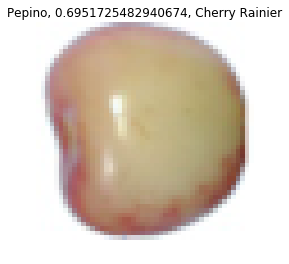

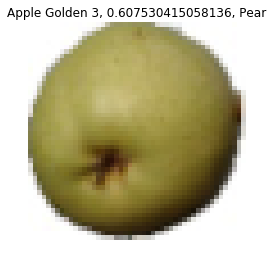

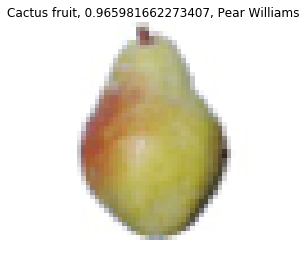

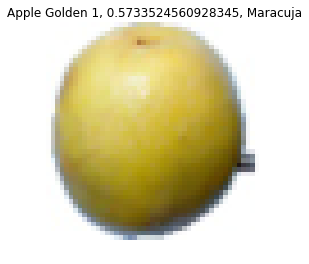

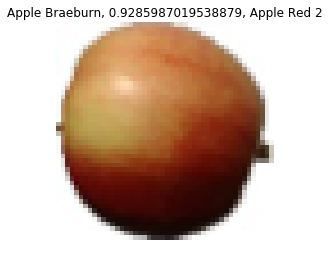

In [18]:
show_images(test[test.nombres_frutas != test.prediction].sample(5), title=['prediction', 'prediction_confidence','nombres_frutas'])

### Red Neuronal Convolucional

Como segunda técnica creamos un modelo de red neuronal Convolucional.

Definimos 2 capas de convoluciones con activación relu, una de tipo MaxPooling, luego con flatten lo que hacemos es transformar las salidas de las capas anteriores (que son multidimensionales) para poder armar una lista que le sirva como entrada a las capas siguientes. 

Luego definimos dos capas intermedias con activación relu, y como salida una capa con activación softmax. 

Utilizamos "dropouts" a modo de prevenir un poco el posible sobreentrenamiento de la red.

In [19]:
model_convolutional = Sequential([
    Convolution2D(8, (4,4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
    
    Convolution2D(8, (4,4), activation='relu'),
    
    MaxPooling2D(pool_size=(4,4)),
    
    Dropout(0.2),
    
    Flatten(),
    
    Dense(500, activation='relu'),
    
    Dropout(0.2),
    
    Dense(300, activation='relu'),
    
    Dropout(0.2),
    
    Dense(len(FRUTAS), activation='softmax'),
])

model_convolutional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

model_convolutional.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 45, 45, 8)         392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 8)         1032      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               400500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
__________

Entrenamos la red neuronal. 

In [20]:
history_convolutional = model_convolutional.fit(
    extract_inputs_convolutional(train),
    extract_outputs(train),
    epochs=8,
    batch_size=128,
    validation_data=(
        extract_inputs_convolutional(test),
        extract_outputs(test),
    )
)

Train on 31688 samples, validate on 10657 samples
Epoch 1/8
31688/31688 [==============================] - 148s 5ms/step - loss: 1.3746 - acc: 0.6182 - val_loss: 0.2417 - val_acc: 0.9292
Epoch 2/8
31688/31688 [==============================] - 154s 5ms/step - loss: 0.1985 - acc: 0.9354 - val_loss: 0.1709 - val_acc: 0.9435
Epoch 3/8
31688/31688 [==============================] - 142s 4ms/step - loss: 0.0960 - acc: 0.9671 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 4/8
31688/31688 [==============================] - 146s 5ms/step - loss: 0.0661 - acc: 0.9770 - val_loss: 0.1201 - val_acc: 0.9595
Epoch 5/8
31688/31688 [==============================] - 144s 5ms/step - loss: 0.0532 - acc: 0.9808 - val_loss: 0.1557 - val_acc: 0.9458
Epoch 6/8
31688/31688 [==============================] - 142s 4ms/step - loss: 0.0422 - acc: 0.9834 - val_loss: 0.1225 - val_acc: 0.9573
Epoch 7/8
31688/31688 [==============================] - 145s 5ms/step - loss: 0.0357 - acc: 0.9851 - val_loss: 0.1044 - val_acc

Comparamos las curvas de aprendizaje.

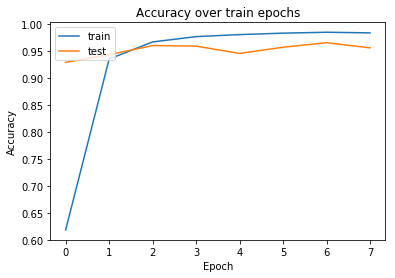

In [21]:
plt.plot(history_convolutional.history['acc'], label='train')
plt.plot(history_convolutional.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

A continuación vamos a visualizar, la matriz de confusión de ambos set de datos, esto puede ayudarnos a definir con qué valores está teniendo problemas el modelo, si hay frutas que está prediciendo siempre o si hay frutas con las que tiene gran dificultad en predecirlas.

                               ######################### train #########################
accuracy 0.993151981823
precision_score 0.994866878458
recall 0.993627201897


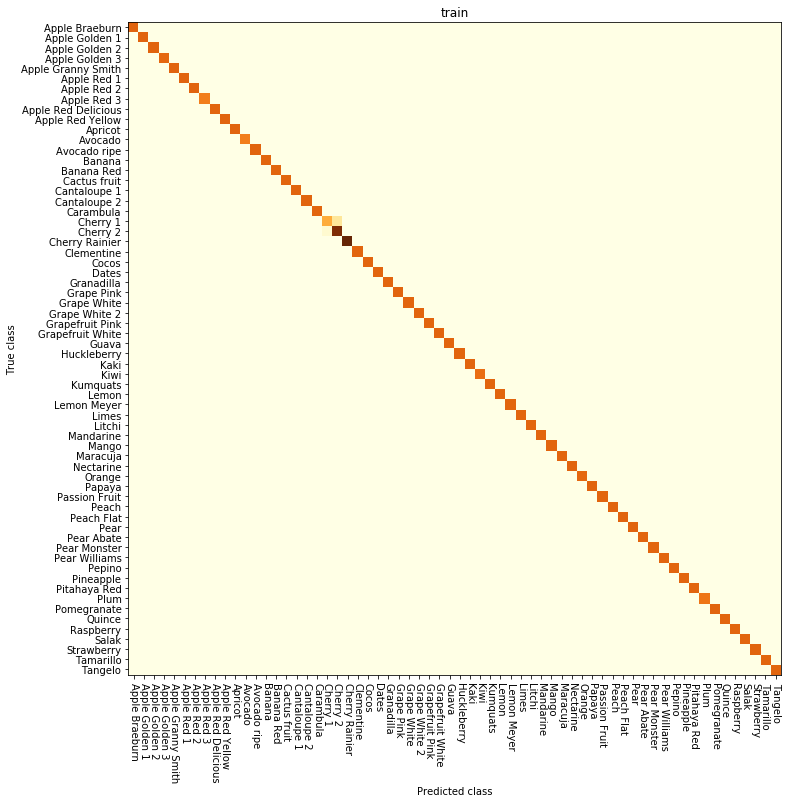

                               ######################### test #########################
accuracy 0.956179037253
precision_score 0.961323493698
recall 0.957281774886


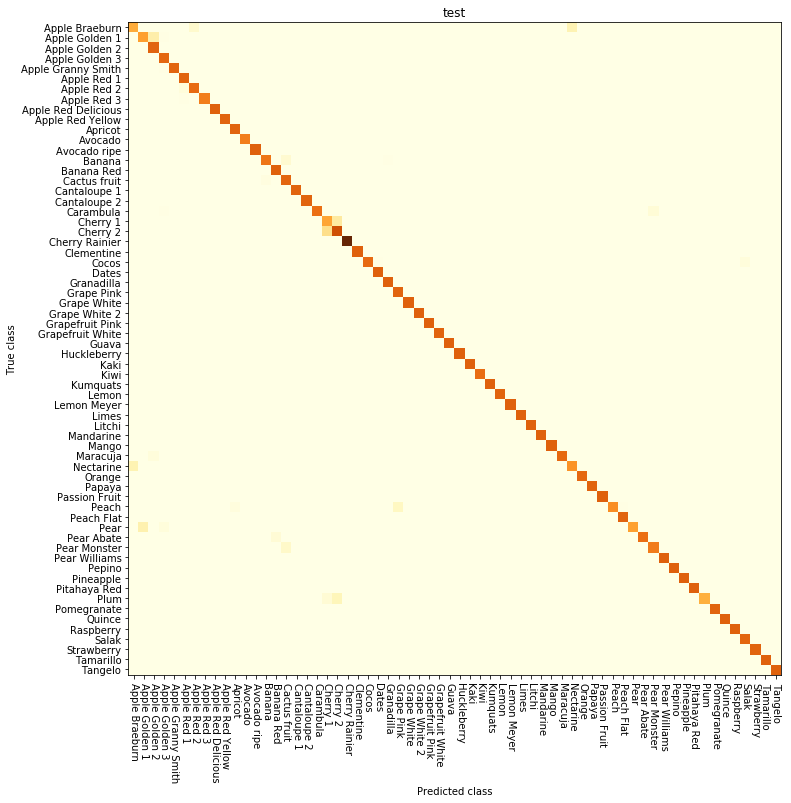

In [22]:
numeros_frutas = [i for i in range(len(FRUTAS))]
for set_name, set_data in sets:
    add_predictions_convolutional(set_data)
    
    print(' ' * 30,'#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(set_data.nombres_frutas, set_data.prediction))
    print('precision_score', precision_score(set_data.nombres_frutas, set_data.prediction, average="macro"))
    print('recall', recall_score(set_data.nombres_frutas, set_data.prediction, average="macro"))
    
    # plot confussion matrix
    
    plt.figure(figsize=(16,12))
    
    plt.xticks(numeros_frutas, FRUTAS, rotation=270)
    plt.yticks(numeros_frutas, FRUTAS)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    
    plt.title(set_name)
    
    plt.imshow(
        confusion_matrix(set_data.nombres_frutas, set_data.prediction),
        cmap=plt.cm.YlOrBr,
        interpolation='nearest',
    )
    
    plt.show()

Para finalizar con este modelo, también vamos a mostrar ejemplos de predicciones realizadas por el mismo.

#### Predicciones correctas
En la imagen se muestra el valor que predijo el modelo, el valor de "confianza", y la fruta que era en realidad.

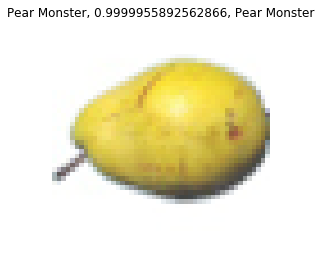

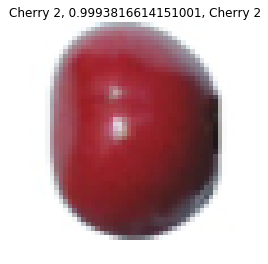

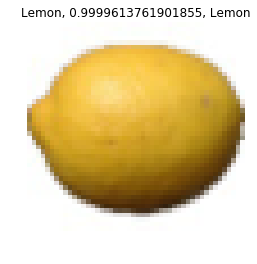

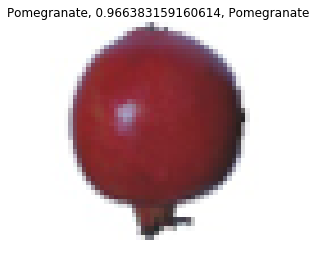

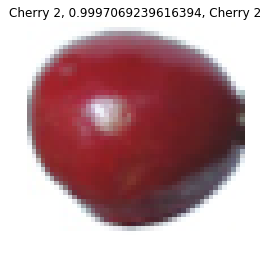

In [23]:
show_images(test[test.nombres_frutas == test.prediction].sample(5), title=['prediction', 'prediction_confidence','nombres_frutas'])

#### Predicciones incorrectas
En la imagen se muestra el valor que predijo el modelo, el valor de "confianza", y la fruta que era en realidad.

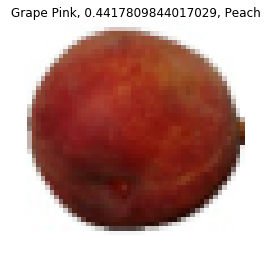

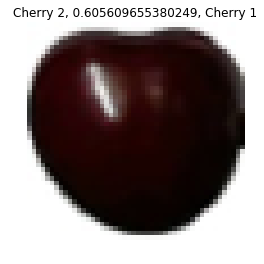

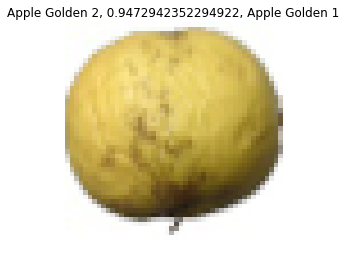

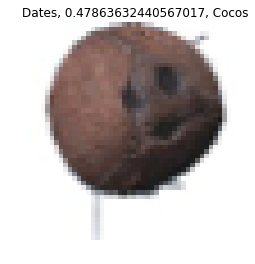

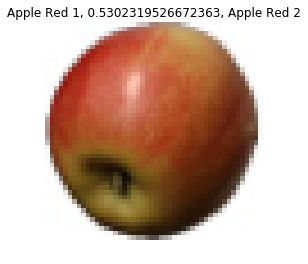

In [24]:
show_images(test[test.nombres_frutas != test.prediction].sample(5), title=['prediction', 'prediction_confidence','nombres_frutas'])

### Concluciones finales

Como podemos observar, ambos modelos arrojaron resultados muy buenos teniendo en cuenta las distintas métricas. Tanto la red neuronal MLP como la red neuronal convolucional obtuvieron un accuracy mayor al 0,90% tanto en train como en test, por lo que podríamos decir que ambos modelos podrían ser utilizados para predecir en este caso. 

Estos valores se deben a que el dataset contaba con imágenes sin "ruido", estaban bien recortadas, todas con fondo blanco, sólo se encontraba la fruta y nada más, había una buena cantidad de datos tanto para entrenar como para testear los modelos. Podemos decir que era una situación ideal para utilizar algoritmos de machine learning y obtener buenos resultados. 